# **Import Libraries**

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score
import nltk
from textblob import TextBlob
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# **Survey Data Load**

In [3]:
survey_data = pd.read_csv('survey.csv')
survey_data.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [4]:
survey_data.isnull().sum()

,0
Timestamp,0
Age,0
Gender,0
Country,0
state,515
self_employed,18
family_history,0
treatment,0
work_interfere,264
no_employees,0


# **Preprocessing for Survey Dataset**


In [5]:
survey_data['state'] = survey_data['state'].fillna('Unknown')
survey_data['self_employed'] = survey_data['self_employed'].fillna(survey_data['self_employed'].mode()[0])
survey_data['work_interfere'] = survey_data['work_interfere'].fillna('Unknown')
survey_data = survey_data.dropna(subset=['comments'])
survey_data['Age'] = survey_data['Age'].fillna(survey_data['Age'].median())

In [6]:
survey_data = pd.get_dummies(survey_data, columns=['Gender', 'Country', 'self_employed', 'treatment', 'work_interfere',
                                                   'remote_work', 'tech_company', 'benefits', 'care_options',
                                                   'wellness_program', 'seek_help', 'anonymity',
                                                   'mental_health_consequence', 'phys_health_consequence',
                                                   'coworkers', 'supervisor', 'mental_health_interview',
                                                   'phys_health_interview', 'mental_vs_physical', 'obs_consequence'],
                             drop_first=True)

In [7]:
survey_data = survey_data.drop('Timestamp', axis=1)

In [8]:
survey_data = survey_data.dropna()

In [9]:
survey_data.head()

,Age,state,family_history,no_employees,leave,comments,Gender_Androgyne,Gender_Cis Male,Gender_F,Gender_Female,...,coworkers_Yes,supervisor_Some of them,supervisor_Yes,mental_health_interview_No,mental_health_interview_Yes,phys_health_interview_No,phys_health_interview_Yes,mental_vs_physical_No,mental_vs_physical_Yes,obs_consequence_Yes
13,36,CT,Yes,500-1000,Don't know,I'm not on my company's health insurance which...,False,False,False,False,...,True,False,True,True,False,True,False,False,False,False
15,29,IL,Yes,26-100,Somewhat easy,I have chronic low-level neurological issues t...,False,False,False,False,...,True,True,False,False,False,False,False,False,False,False
16,23,Unknown,No,26-100,Very easy,My company does provide healthcare but not to ...,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
24,33,CA,Yes,26-100,Don't know,Relatively new job. Ask again later,False,False,False,False,...,True,False,True,True,False,False,True,False,False,False
25,35,TN,Yes,More than 1000,Very easy,Sometimes I think about using drugs for my me...,False,False,False,False,...,False,False,True,True,False,False,True,True,False,False


# **EDA**

### **Demographic Features Exploration**

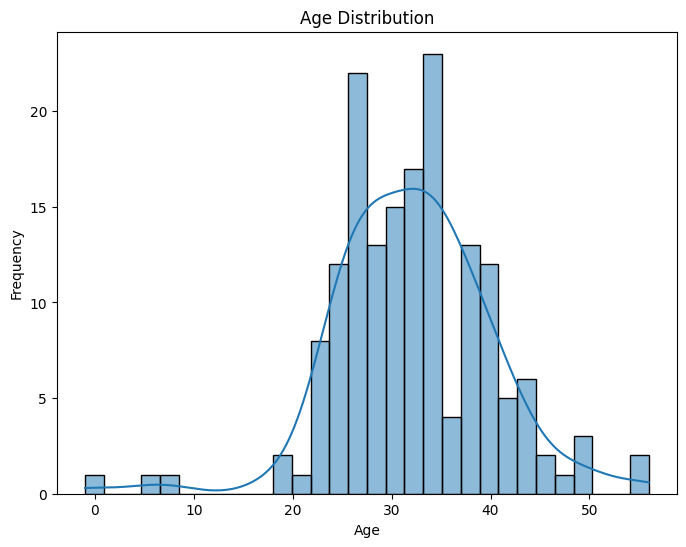

In [10]:
plt.figure(figsize=(8,6))
sns.histplot(survey_data['Age'], kde=True, bins=30)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


<ipython-input-11-e2f11a26ef51>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_data.index, y=gender_data.values, palette='Set2')


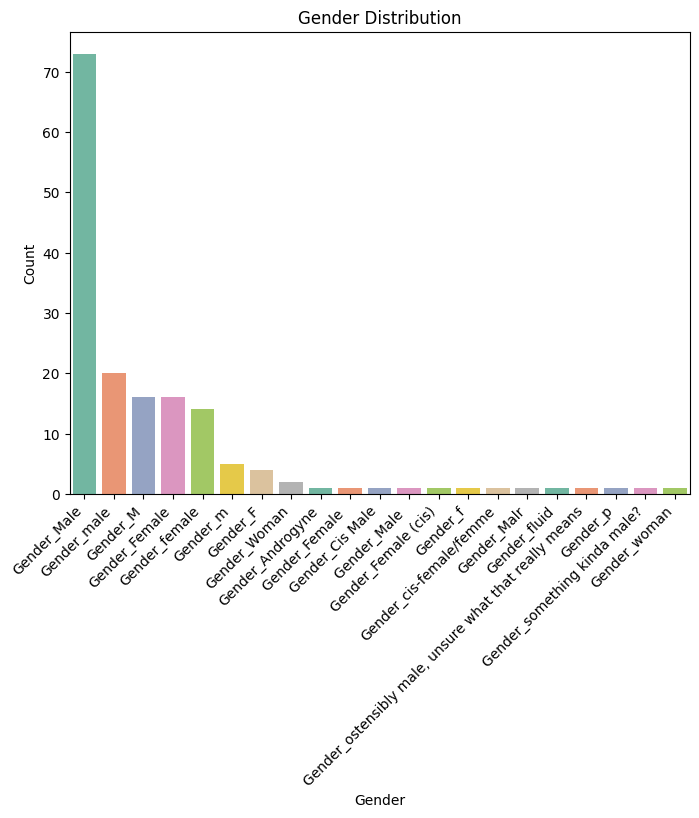

In [11]:
gender_columns = [col for col in survey_data.columns if 'Gender' in col]
gender_data = survey_data[gender_columns].sum()
gender_data = gender_data.sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=gender_data.index, y=gender_data.values, palette='Set2')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

<ipython-input-12-3b9a35e7c789>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_data.index, y=country_data.values, palette='Set3')


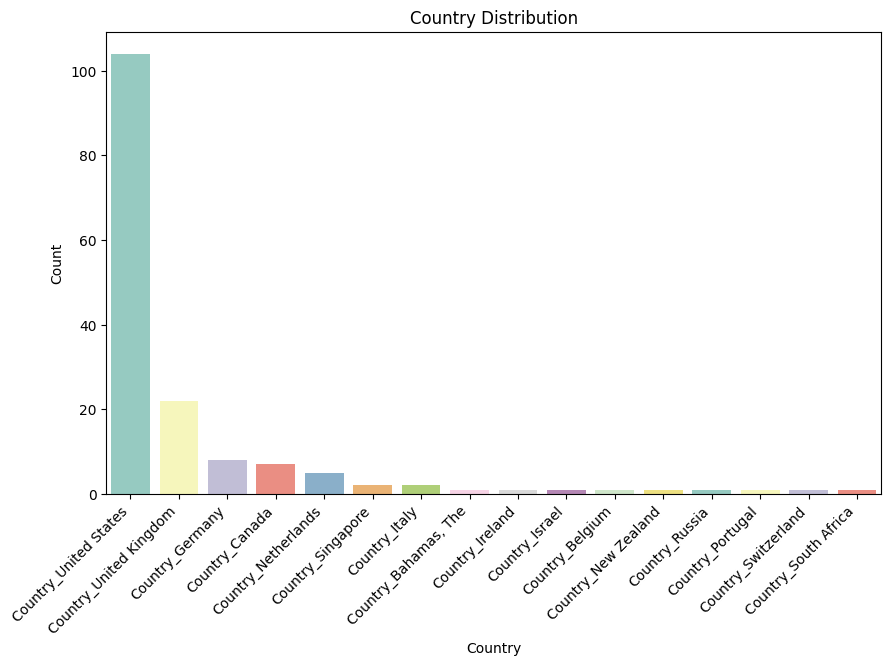

In [12]:
country_columns = [col for col in survey_data.columns if 'Country' in col]
country_data = survey_data[country_columns].sum()
country_data = country_data.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=country_data.index, y=country_data.values, palette='Set3')
plt.title('Country Distribution')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

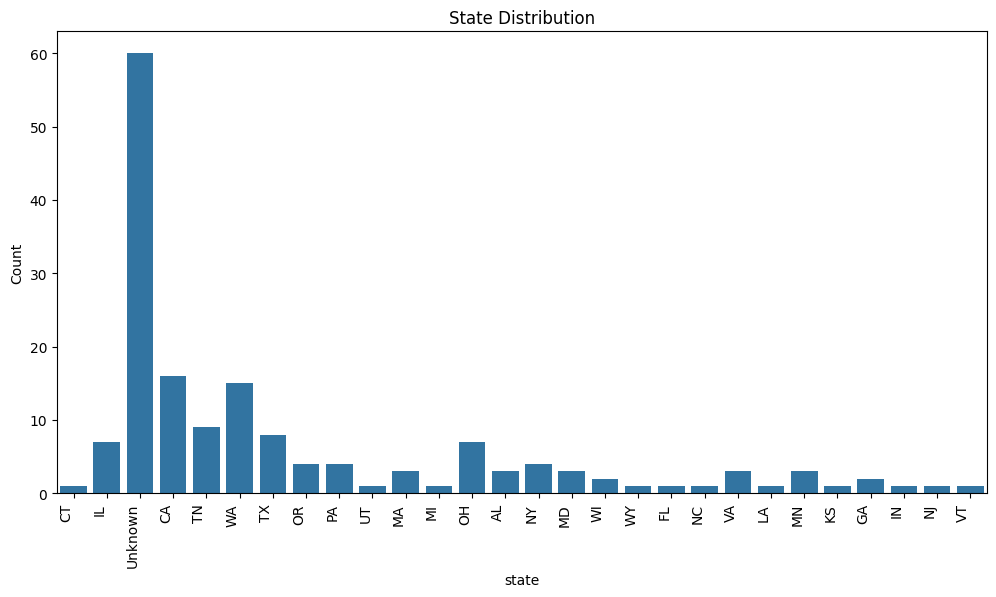

In [13]:
plt.figure(figsize=(12,6))
sns.countplot(data=survey_data, x='state')
plt.title('State Distribution')
plt.xticks(rotation=90, ha='right')
plt.ylabel('Count')
plt.show()

### **Behavioral Features Exploration**

<ipython-input-14-4e96a9c3598b>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='self_employed_Yes', data=survey_data, palette='Pastel1')


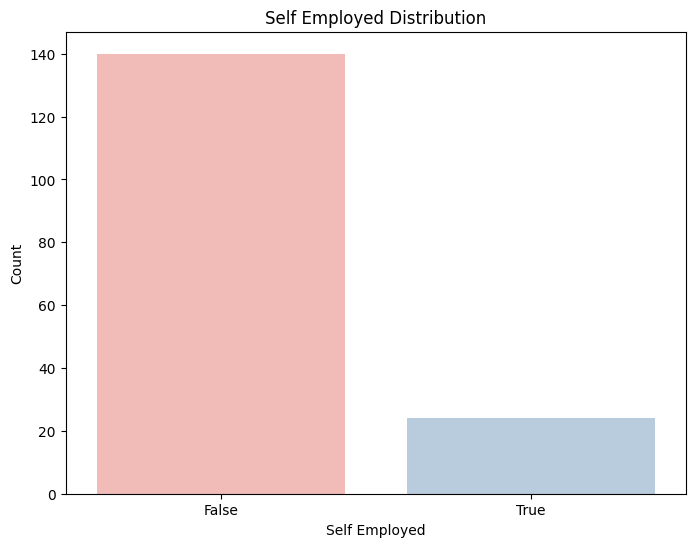

In [14]:
plt.figure(figsize=(8, 6))
sns.countplot(x='self_employed_Yes', data=survey_data, palette='Pastel1')
plt.title('Self Employed Distribution')
plt.xlabel('Self Employed')
plt.ylabel('Count')
plt.show()

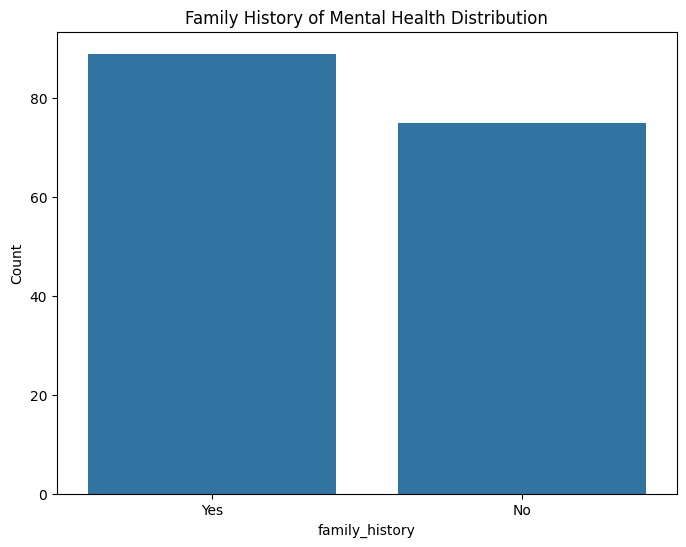

In [15]:
plt.figure(figsize=(8,6))
sns.countplot(data=survey_data, x='family_history')
plt.title('Family History of Mental Health Distribution')
plt.ylabel('Count')
plt.show()

<ipython-input-16-63b1eaf04d95>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='treatment_Yes', data=survey_data, palette='muted')


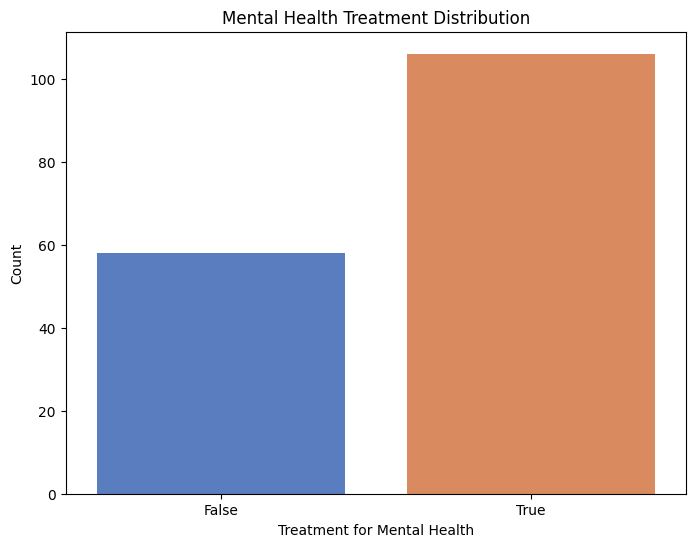

In [16]:
plt.figure(figsize=(8, 6))
sns.countplot(x='treatment_Yes', data=survey_data, palette='muted')
plt.title('Mental Health Treatment Distribution')
plt.xlabel('Treatment for Mental Health')
plt.ylabel('Count')
plt.show()

<ipython-input-17-4ab9706b3b64>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=work_interference_data.index, y=work_interference_data.values, palette='coolwarm')


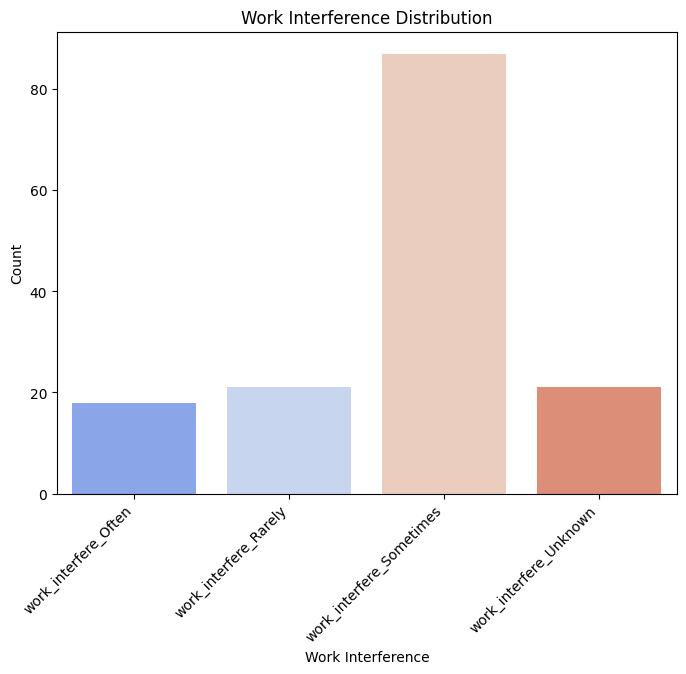

In [17]:
work_interference = ['work_interfere_Often', 'work_interfere_Rarely',
                     'work_interfere_Sometimes', 'work_interfere_Unknown']
work_interference_data = survey_data[work_interference].sum()

plt.figure(figsize=(8, 6))
sns.barplot(x=work_interference_data.index, y=work_interference_data.values, palette='coolwarm')
plt.title('Work Interference Distribution')
plt.xlabel('Work Interference')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()


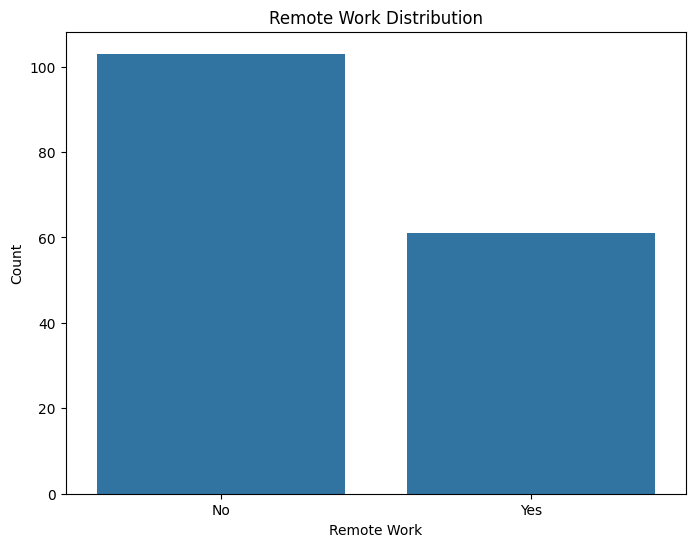

In [18]:
plt.figure(figsize=(8,6))
sns.countplot(data=survey_data, x='remote_work_Yes')
plt.title('Remote Work Distribution')
plt.ylabel('Count')
plt.xlabel('Remote Work')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.show()


### **Psychological Features Exploration**

<ipython-input-19-cb743d64455d>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mental_health_consequence_data.index, y=mental_health_consequence_data.values, palette='Blues')


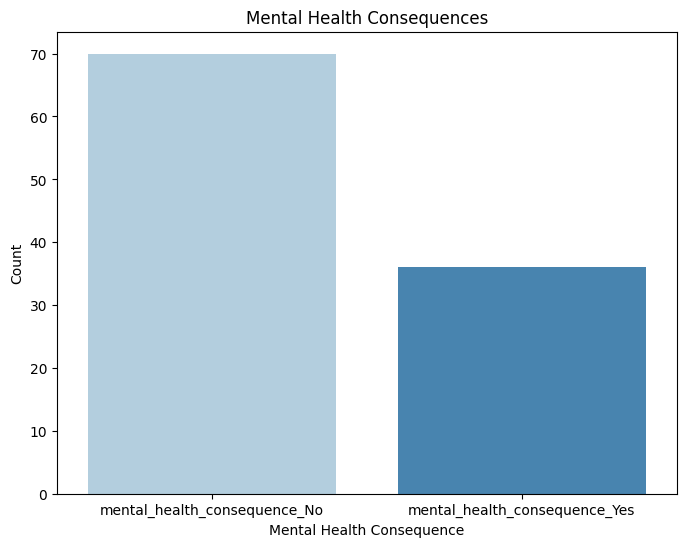

In [19]:
mental_health_consequence = ['mental_health_consequence_No', 'mental_health_consequence_Yes']
mental_health_consequence_data = survey_data[mental_health_consequence].sum()

plt.figure(figsize=(8, 6))
sns.barplot(x=mental_health_consequence_data.index, y=mental_health_consequence_data.values, palette='Blues')
plt.title('Mental Health Consequences')
plt.xlabel('Mental Health Consequence')
plt.ylabel('Count')
plt.show()

<ipython-input-20-c4e5c413f876>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=physical_health_consequence_data.index, y=physical_health_consequence_data.values, palette='Purples')


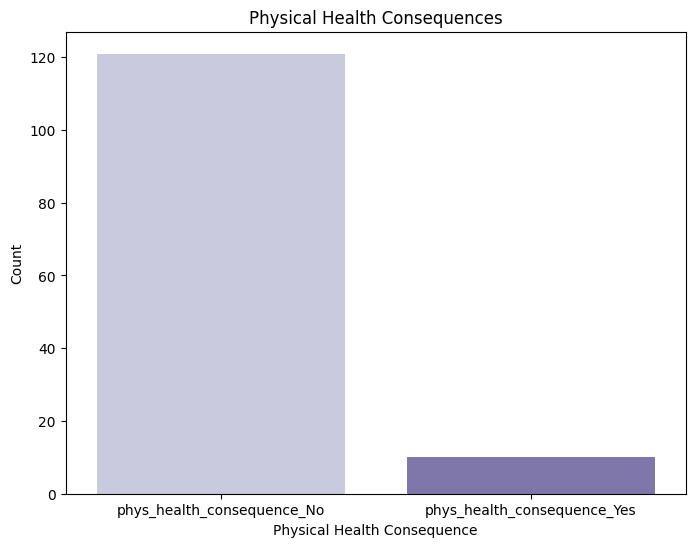

In [20]:
physical_health_consequence = ['phys_health_consequence_No', 'phys_health_consequence_Yes']
physical_health_consequence_data = survey_data[physical_health_consequence].sum()

plt.figure(figsize=(8, 6))
sns.barplot(x=physical_health_consequence_data.index, y=physical_health_consequence_data.values, palette='Purples')
plt.title('Physical Health Consequences')
plt.xlabel('Physical Health Consequence')
plt.ylabel('Count')
plt.show()

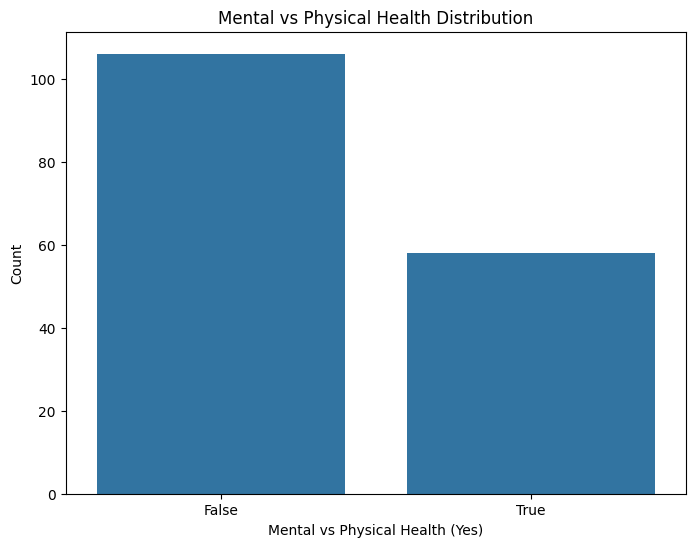

In [21]:
plt.figure(figsize=(8,6))
sns.countplot(data=survey_data, x='mental_vs_physical_Yes')
plt.title('Mental vs Physical Health Distribution')
plt.ylabel('Count')
plt.xlabel('Mental vs Physical Health (Yes)')
plt.show()


### **Physical Health Features Exploration**

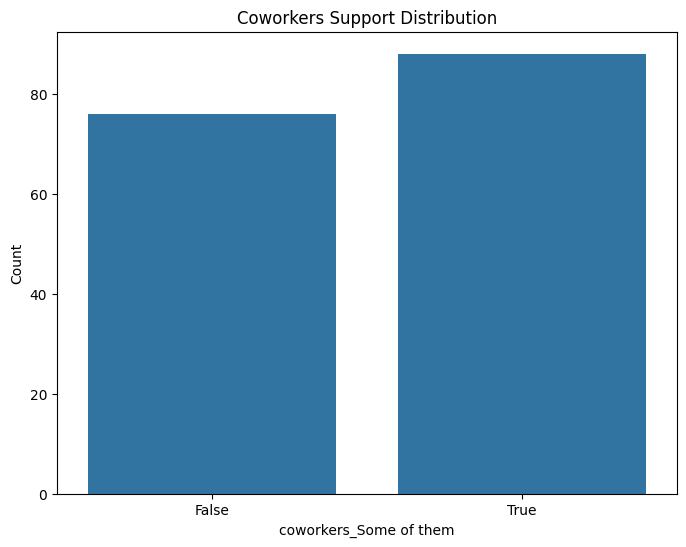

In [22]:
plt.figure(figsize=(8,6))
sns.countplot(data=survey_data, x='coworkers_Some of them')
plt.title('Coworkers Support Distribution')
plt.ylabel('Count')
plt.show()

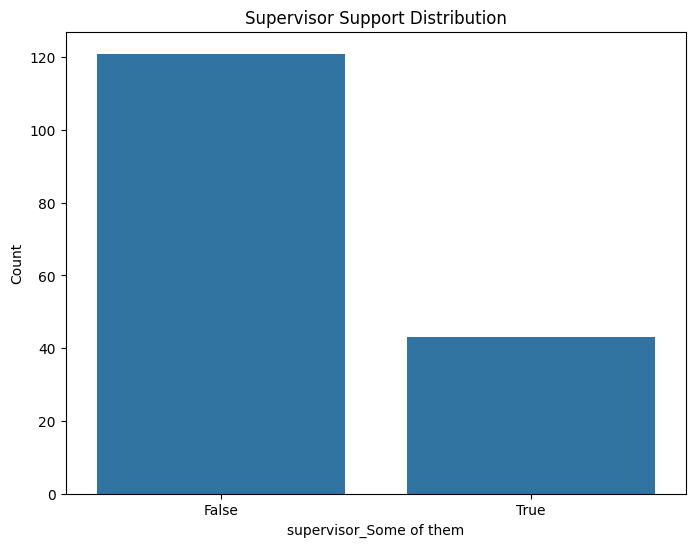

In [23]:
plt.figure(figsize=(8,6))
sns.countplot(data=survey_data, x='supervisor_Some of them')
plt.title('Supervisor Support Distribution')
plt.ylabel('Count')
plt.show()

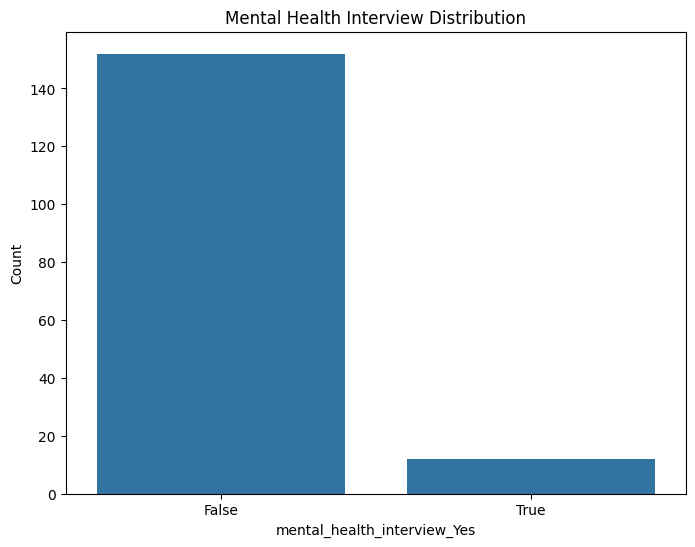

In [24]:
plt.figure(figsize=(8,6))
sns.countplot(data=survey_data, x='mental_health_interview_Yes')
plt.title('Mental Health Interview Distribution')
plt.ylabel('Count')
plt.show()


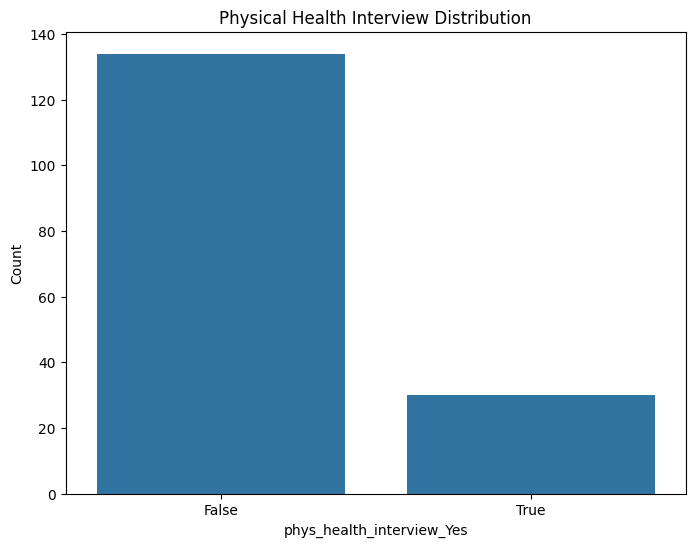

In [25]:
plt.figure(figsize=(8,6))
sns.countplot(data=survey_data, x='phys_health_interview_Yes')
plt.title('Physical Health Interview Distribution')
plt.ylabel('Count')
plt.show()


# **Mental Health Data Load**

In [26]:
mental_health_data = pd.read_csv('Combined Data.csv')
mental_health_data.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


# **Text Cleanning on Mental Health Dataset**

In [27]:
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'[^\w\s]', '', text)
    else:
        text = ''
    return text

mental_health_data['cleaned_text'] = mental_health_data['statement'].apply(clean_text)


In [28]:
mental_health_data.head()

,Unnamed: 0,statement,status,cleaned_text
0,0,oh my gosh,Anxiety,oh my gosh
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety,trouble sleeping confused mind restless heart ...
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,all wrong back off dear forward doubt stay in ...
3,3,I've shifted my focus to something else but I'...,Anxiety,ive shifted my focus to something else but im ...
4,4,"I'm restless and restless, it's been a month n...",Anxiety,im restless and restless its been a month now ...


# **Bigram Analysis**

In [29]:
def get_bigrams(text):
    tokens = word_tokenize(text.lower())
    bigrams = list(ngrams(tokens, 2))
    return bigrams

In [30]:
def plot_bigrams(bigram_freq, title):
    bigram_df = pd.DataFrame(bigram_freq.most_common(10), columns=['Bigram', 'Frequency'])
    bigram_df['Bigram'] = bigram_df['Bigram'].apply(lambda x: ' '.join(x))
    plt.figure(figsize=(10,5))
    sns.barplot(x='Frequency', y='Bigram', data=bigram_df, palette='viridis')
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("Bigrams")
    plt.show()

<ipython-input-30-12acbc947463>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Bigram', data=bigram_df, palette='viridis')


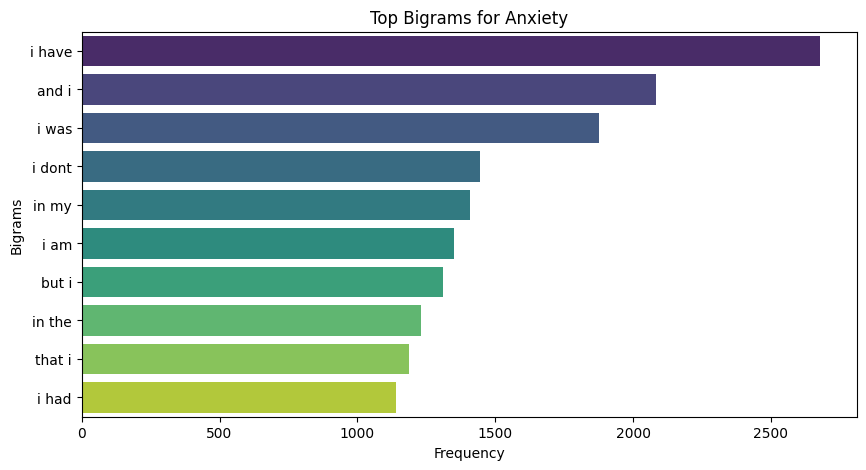

<ipython-input-30-12acbc947463>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Bigram', data=bigram_df, palette='viridis')


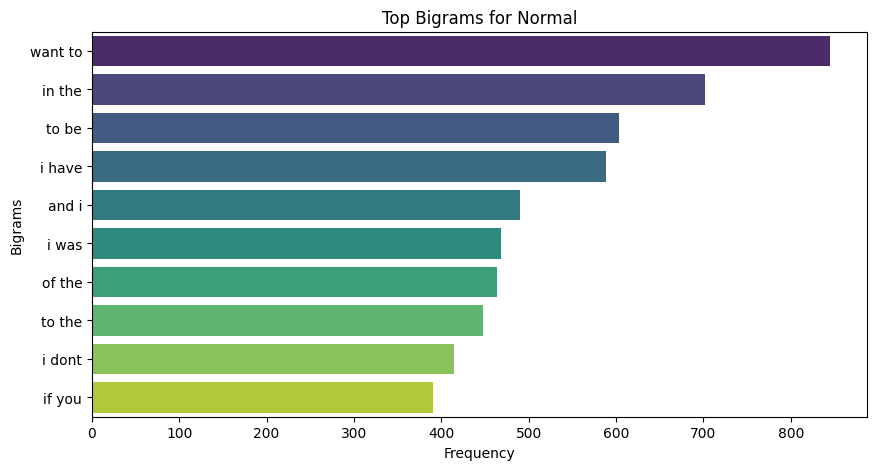

<ipython-input-30-12acbc947463>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Bigram', data=bigram_df, palette='viridis')


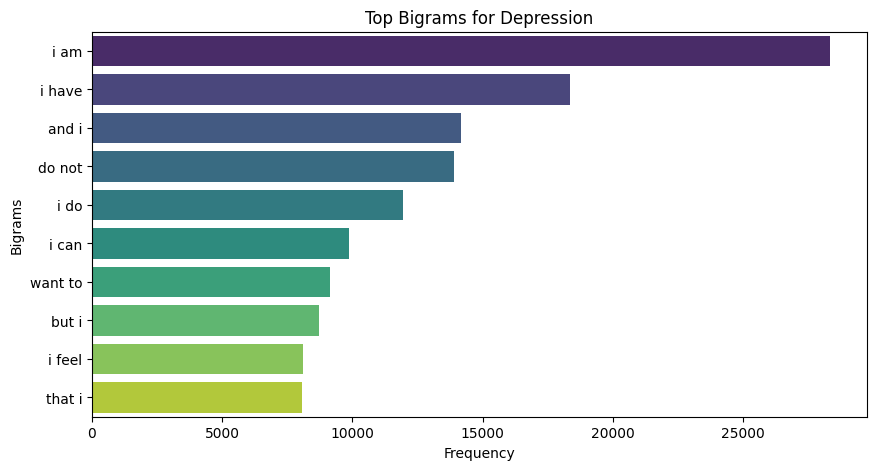

<ipython-input-30-12acbc947463>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Bigram', data=bigram_df, palette='viridis')


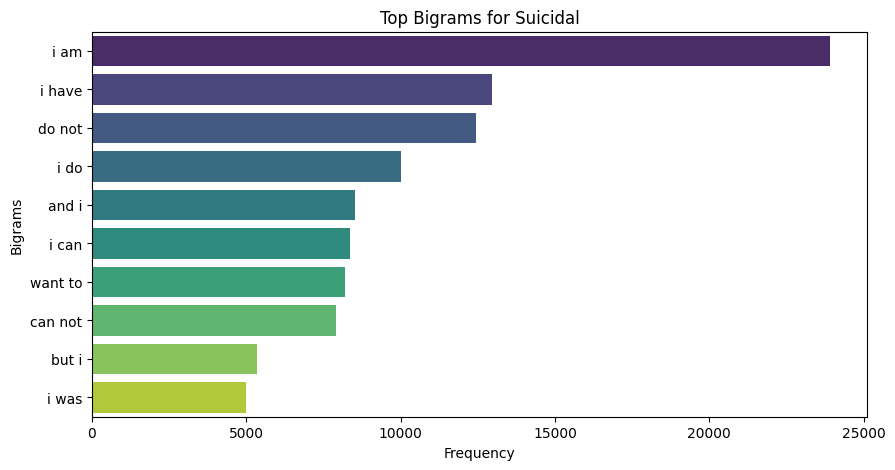

<ipython-input-30-12acbc947463>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Bigram', data=bigram_df, palette='viridis')


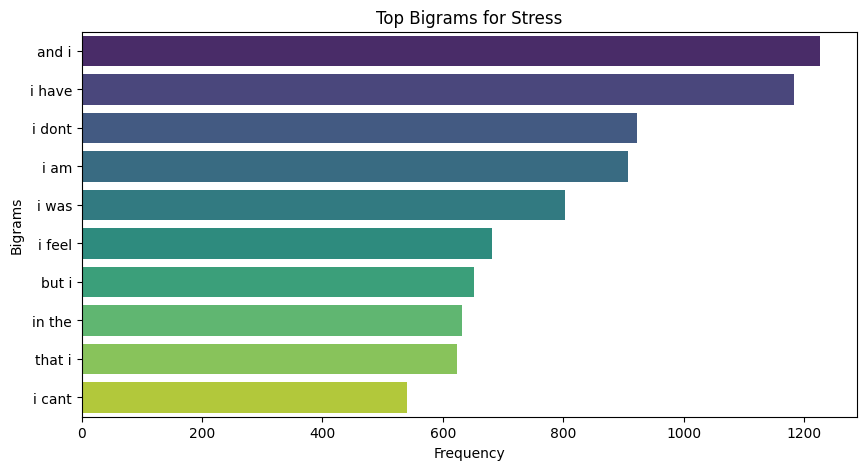

<ipython-input-30-12acbc947463>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Bigram', data=bigram_df, palette='viridis')


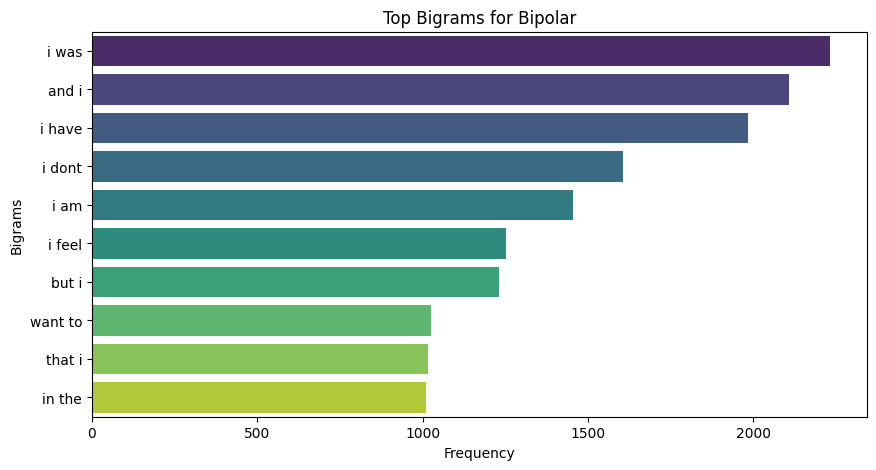

<ipython-input-30-12acbc947463>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Bigram', data=bigram_df, palette='viridis')


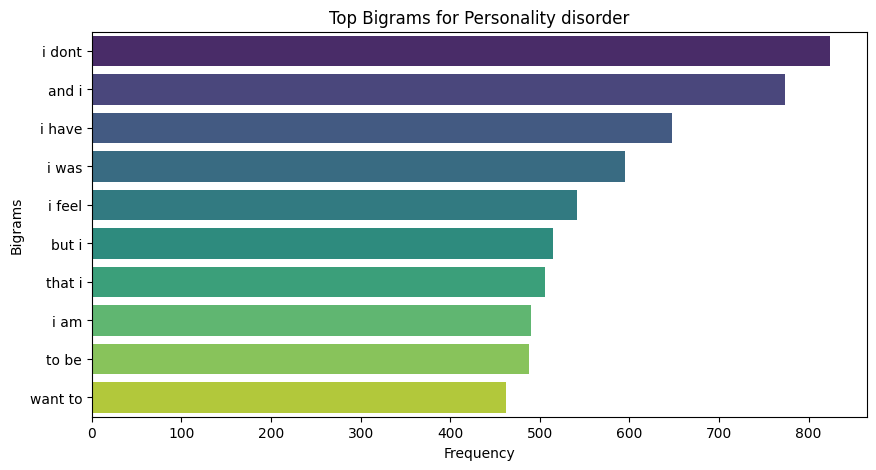

In [31]:
for status in mental_health_data['status'].unique():
    status_texts = ' '.join(mental_health_data[mental_health_data['status'] == status]['cleaned_text'])

    bigrams = get_bigrams(status_texts)
    bigram_freq = Counter(bigrams)
    plot_bigrams(bigram_freq, f"Top Bigrams for {status}")

# **Word Cloud**

In [32]:
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

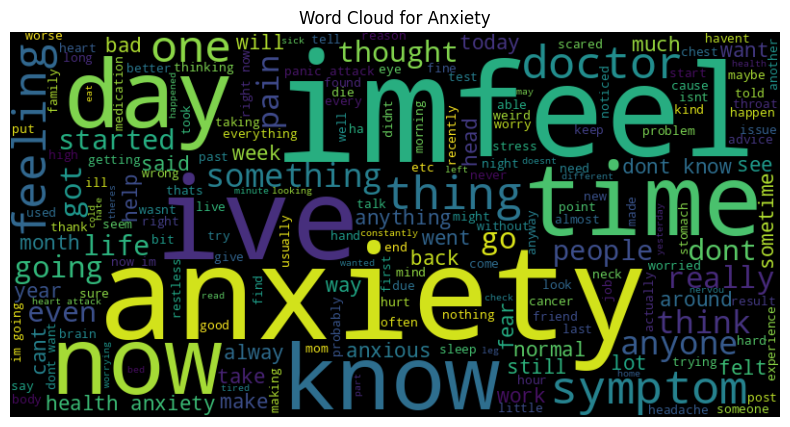

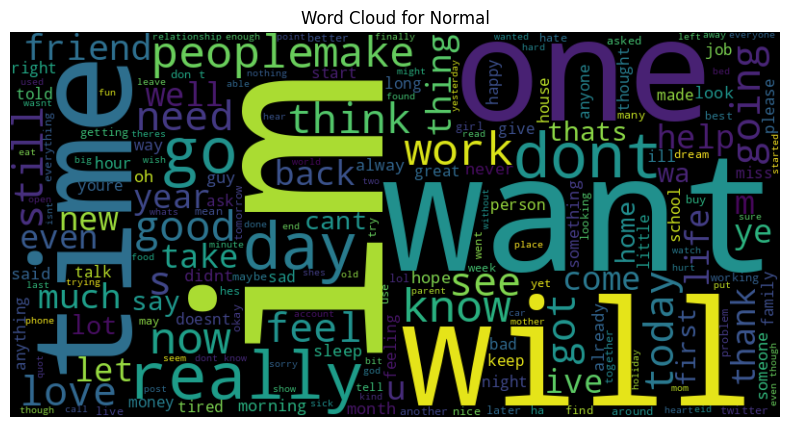

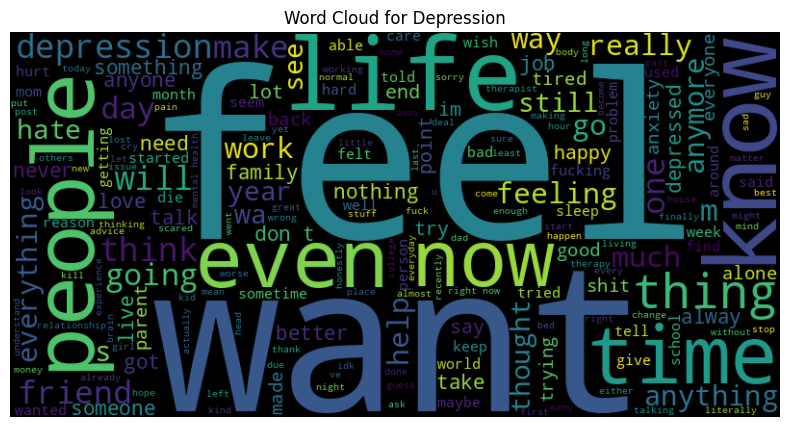

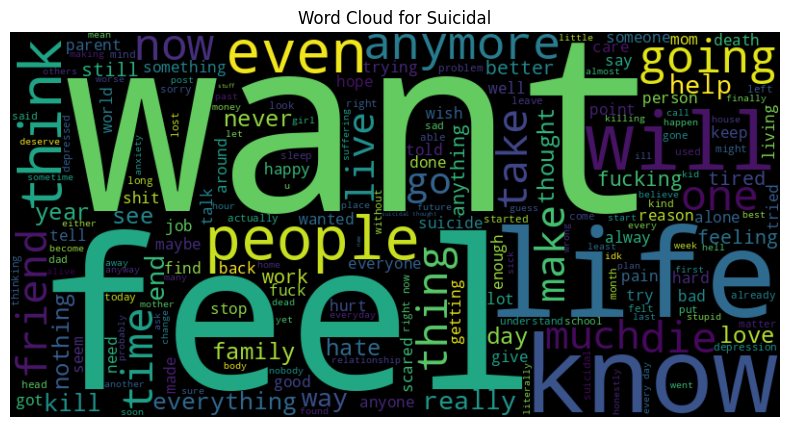

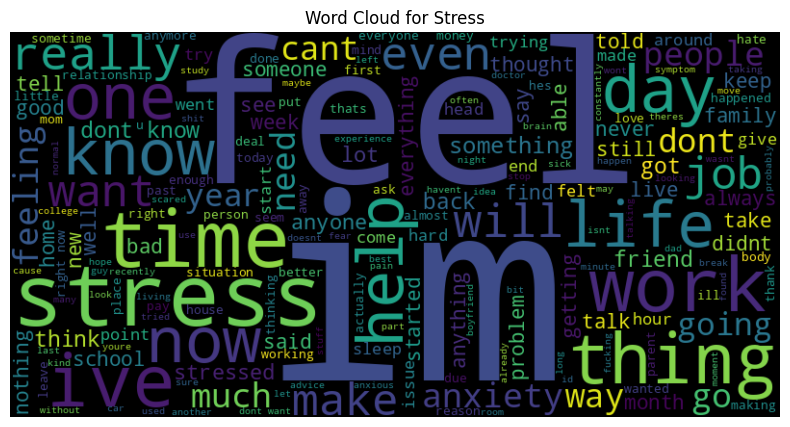

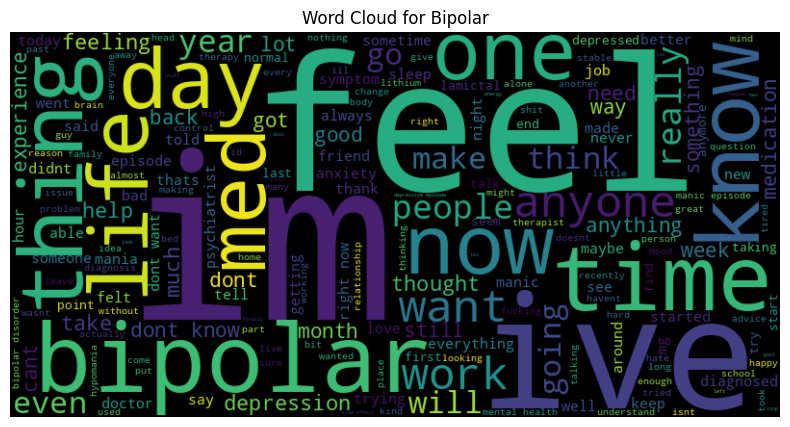

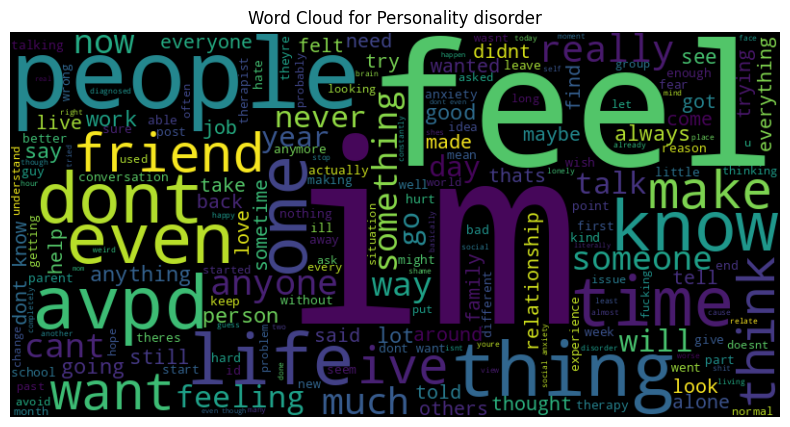

In [33]:
for status in mental_health_data['status'].unique():
    status_texts = ' '.join(mental_health_data[mental_health_data['status'] == status]['cleaned_text'])
    generate_wordcloud(status_texts, f"Word Cloud for {status}")

# **Vectorization**

In [34]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(mental_health_data['cleaned_text'])
y = mental_health_data['status'].values

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Random Forest**

In [36]:
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42
)

model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# **Accuracy**

In [37]:
y_pred = model.predict(X_test)
print("Sentiment Analysis Model Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))


Sentiment Analysis Model Accuracy: 0.74


# **Chatbot Creation**

In [42]:
def chatbot_response(user_input):
    cleaned_input = clean_text(user_input)
    vectorized_input = vectorizer.transform([cleaned_input])
    prediction = model.predict(vectorized_input)[0]

    print(f"Debug: Model predicted -> {prediction}")

    responses = {
        "Anxiety": "I'm here for you. Anxiety can be overwhelming, but take a deep breath and know that you're not alone.",
        "Bipolar": "I understand that managing bipolar disorder can be challenging. Seeking support from loved ones and professionals can help.",
        "normal": "It's great to hear that you're feeling okay! If you ever need to talk, I'm here to listen.",
        "depression": "I'm so sorry you're feeling this way. You're not alone, and there are people who care about you and want to help.",
        "personality disorder": "It must be tough dealing with this. Remember, you're strong, and with the right support, you can manage it.",
        "stress": "Stress can be difficult to handle. Try to take breaks, practice deep breathing, and take care of yourself.",
        "suicidal": "I'm really sorry you're feeling this way. Please reach out to someone you trust or a professional. You matter, and help is available."
    }

    prediction = prediction.strip().capitalize()

    return responses.get(prediction, f"I'm here to support you. You're not alone, and things can get better.")

In [44]:
print("Hello! I am your mental health chatbot. Type 'exit' to quit.")
while True:
    user_input = input("You: ")
    if user_input.lower() == 'exit':
        print("Goodbye! Take care.")
        break
    response = chatbot_response(user_input)
    print(f"Bot: {response}")

Hello! I am your mental health chatbot. Type 'exit' to quit.
You: I want to die
Debug: Model predicted -> Suicidal
Bot: I'm here to support you. You're not alone, and things can get better.
You: I am very worried
Debug: Model predicted -> Anxiety
Bot: I'm here for you. Anxiety can be overwhelming, but take a deep breath and know that you're not alone.
You: exit
Goodbye! Take care.
